In [64]:
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups
import re
import scattertext as ST
import spacy
import mpld3
import matplotlib.pyplot as plt
mpld3.enable_notebook()

In [81]:
nlp = spacy.en.English()

## Load newsgroup dataset

In [66]:
categories = ['alt.atheism', 'talk.religion.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories)

In [95]:
# function to strip out headers from newsgroup posts, remove last full line
def clean_newsgroup_data_factory():
    badline_re = re.compile(r'(^(>|From:|Subject:|Organization:'+
                            '|Distribution:|NNTP-Posting-Host:|Lines:|News-Software:'
                            +'|In article <.+?@.+>)|(writes:?|.com|.edu|.org)$)')
    email_address_finder = re.compile(r'\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b', flags=re.IGNORECASE)
    def clean_newsgroup_data(text):
        return '\n'.join([email_address_finder.sub('', line)
                          for line in text.split('\n') 
                          if badline_re.match(line.strip()) is None][:-1])
    return clean_newsgroup_data

In [96]:
term_doc_matrix_factory = ST.TermDocMatrixFactory(
        category_iter = (categories[idx] for idx in newsgroups.target), # only pass in full category names
        text_iter = newsgroups.data,
        clean_function = clean_newsgroup_data_factory(),
        nlp = nlp)
term_doc_matrix = term_doc_matrix_factory.build()


# See what stands out in the data set against English as a whole

In [97]:
(term_doc_matrix
 .get_scaled_f_score_scores_vs_background()
 .iloc[:10])
# we can also use get_rudder_scores_vs_background, 
# get_posterior_mean_ratio_scores_vs_background, 
# or get_fisher_scores_vs_background

,corpus,background,Scaled f-score
koresh,86,73785,0.000647
ksand,42,0,0.000437
atheists,168,795807,0.000340
mozumder,32,0,0.000333
decenso,32,0,0.000333
alink,42,60976,0.000332
livesey,42,78135,0.000311
beauchaine,27,0,0.000281
atheism,153,1022796,0.000252
halat,24,0,0.000250


## See what distinguishes alt.atheism against talk.religion.misc, in terms of Scaled F-Score

In [98]:
df = term_doc_matrix.get_term_freq_df()
df['Scaled f-score'] = term_doc_matrix.get_scaled_f_scores('alt.atheism', scaler_algo = 'percentile')

In [38]:
# other options include get_logistic_regression_coefs_l1, get_rudder_scores, 
#  get_posterior_mean_ratio_scores, and get_fisher_scores
df.sort_values('Scaled f-score', ascending = False).iloc[:10]

,alt.atheism freq,talk.religion.misc freq,Scaled f-score
term,,,
fallacy,59,0,0.803390
keith,81,2,0.795159
atheists,163,5,0.794614
atheist,100,3,0.793864
atheism,148,5,0.791177
bobby,45,0,0.778628
atheism is,36,0,0.754163
g'd,36,0,0.754163
jon,73,5,0.743127


## In terms of distinguishing l2-penalized logistic regression coefs

In [74]:
df['L2 coefs'], acc, baseline = term_doc_matrix.get_logistic_regression_coefs_l2('alt.atheism')
print 'classifier accuracy', acc
print 'majority-class baseline accuracy', baseline
df.sort_values('L2 coefs', ascending=False).iloc[:10]

classifier accuracy 0.833138856476
majority-class baseline accuracy 0.560093348891


,alt.atheism freq,talk.religion.misc freq,Scaled f-score,L2 coefs
term,,,,
keith,81,2,0.795159,1.660585
tammy,19,0,0.683664,1.163220
atheism,148,5,0.791177,1.109775
gregg,30,0,0.733227,1.097085
jon,73,5,0.743127,1.040281
benedikt,37,1,0.733063,1.015038
it,1551,1041,0.200517,0.991604
islam,109,19,0.626258,0.967020
could,167,95,0.256817,0.866263


## The rudder visualization, with posterior ratios as scores.  Write interactive chart and term rankings to alt.atheism.html.

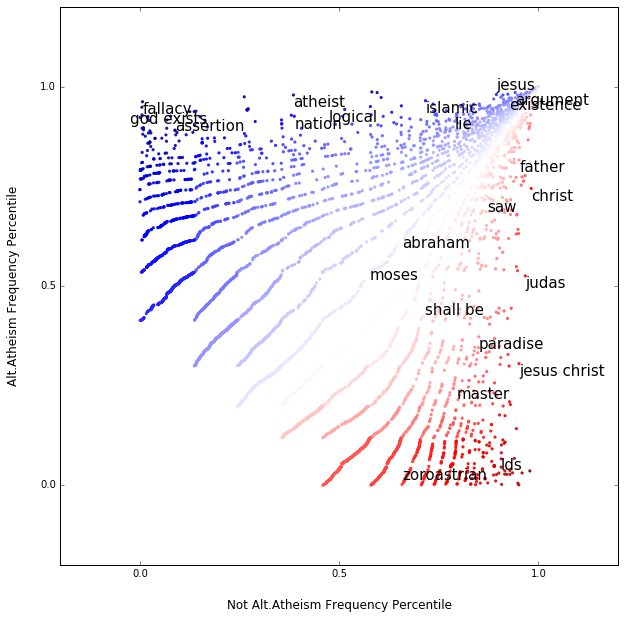

In [106]:
import scattertext as ST
imp.reload(ST)
import scattertext
plt.rcParams['figure.figsize'] = (10, 10)
scatter_chart = ST.ScatterChart(term_doc_matrix,
                                jitter = 0, # 0.05 adds a bit of jitter
                               )
chart_df, chart_html = scatter_chart.draw('alt.atheism',
                      num_top_words_to_annotate = 0,
                      transform = ST.Scalers.percentile_ordinal,
                      scores = term_doc_matrix.get_posterior_mean_ratio_scores('alt.atheism'),
                      words_to_annotate=['lds', 'fallacy', 'assertion', 'god exists', 'logical', 'lie', 'existence', 
                                         'atheist', 'saw', 'shall be', 'paradise', 'argument', 'islamic', 'nation', 
                                         'master', 'jesus', 'abraham', 'moses', 'christ', 'jesus christ',
                                        'judas', 'father', '', 'zoroastrian'])
visualization_fn = open('alt.atheism.html', 'w')
visualization_fn.write(chart_html)
print >>visualization_fn, '<h2>Top terms</h2>'
chart_df.sort_values(by='color_scores', ascending=False)[:30].to_html(visualization_fn)
print >>visualization_fn, '<h2>Bottom terms</h2>'
chart_df.sort_values(by='color_scores', ascending=False)[-30:].to_html(visualization_fn)
visualization_fn.close()